# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [1]:
# installation of sklearn_crfsuite
#!pip install sklearn_crfsuite==0.5.0

#### **1.2** Import necessary libraries

In [2]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [4]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [5]:
# define a function to load json file to a dataframe

def load_json_to_dataframe(file_path):
    """
    Load a JSON file into a pandas DataFrame.

    Parameters:
    - file_path (str): Path to the JSON file.

    Returns:
    - pd.DataFrame: DataFrame containing the JSON data.
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
        df = pd.DataFrame(data)
        return df
    except Exception as e:
        print(f"Error loading JSON file: {e}")
        return None



##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [6]:
# read the json file by giving the file path and create a dataframe
df=load_json_to_dataframe("ingredient_and_quantity.json")

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [7]:
# display first five rows of the dataframe - df
print(df.head())

                                                                                                                                                                                                                                                                                            input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder D

In [8]:
# print the dimensions of dataframe - df
print(df.shape)

(285, 2)


In [9]:
# print the information of the dataframe
print(df.info)


<bound method DataFrame.info of                                                                                                                                                                                                                                                                                               input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                   6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli 

#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [10]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

# Tokenize input
# Tokenize POS



def split_tokens(df):
    """
    Splits the 'input' and 'pos' columns in the DataFrame into 'input_tokens' and 'pos_tokens' respectively.

    Parameters:
    - df (pd.DataFrame): DataFrame with 'input' and 'pos' columns containing space-separated strings.

    Returns:
    - pd.DataFrame: Modified DataFrame with new 'input_tokens' and 'pos_tokens' columns.
    """
    df['input_tokens'] = df['input'].apply(lambda x: x.split() if isinstance(x, str) else [])
    df['pos_tokens'] = df['pos'].apply(lambda x: x.split() if isinstance(x, str) else [])
    return df
split_tokens(df)

,input,pos,input_tokens,pos_tokens
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]"
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]"
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]"
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient qua

In [11]:
# display first five rows of the dataframe - df
print(df.head())

                                                                                                                                                                                                                                                                                            input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                              

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [12]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
def add_token_lengths(df):
    """
    Adds 'input_length' and 'pos_length' columns to the DataFrame by computing the lengths
    of the 'input_tokens' and 'pos_tokens' lists respectively.

    Parameters:
    - df (pd.DataFrame): DataFrame with 'input_tokens' and 'pos_tokens' columns.

    Returns:
    - pd.DataFrame: Modified DataFrame with new 'input_length' and 'pos_length' columns.
    """
    df['input_length'] = df['input_tokens'].apply(len)
    df['pos_length'] = df['pos_tokens'].apply(len)
    return df
add_token_lengths(df)

,input,pos,input_tokens,pos_tokens,input_length,pos_length
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",31,31
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]",34,34
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]",37,37
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient

In [13]:
# check for the equality of input_length and pos_length in the dataframe
def check_lengths_match(df):
    """
    Adds a 'lengths_match' column to the DataFrame indicating whether
    'input_length' and 'pos_length' are equal for each row.

    Parameters:
    - df (pd.DataFrame): DataFrame with 'input_length' and 'pos_length' columns.

    Returns:
    - pd.DataFrame: Modified DataFrame with new 'lengths_match' column.
    """
    df['lengths_match'] = df['input_length'] == df['pos_length']
    return df
check_lengths_match(df)

,input,pos,input_tokens,pos_tokens,input_length,pos_length,lengths_match
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",31,31,True
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]",34,34,True
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]",37,37,True
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient q

##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [14]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
def unique_labels(df):
    """
    Extracts and prints all unique POS labels from the 'pos_tokens' column in the DataFrame.

    Parameters:
    - df (pd.DataFrame): DataFrame with a 'pos_tokens' column containing lists of POS tags.

    Returns:
    - set: A set of unique POS labels.
    """
    unique_pos = set()
    for tokens in df['pos_tokens']:
        if isinstance(tokens, list):
            unique_pos.update(tokens)
    print("Unique POS labels found in the dataset:")
    print(unique_pos)
    return unique_pos
unique_labels(df)

Unique POS labels found in the dataset:
{'unit', 'quantity', 'ingredient'}


{'ingredient', 'quantity', 'unit'}

##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>



<font color = red>[write your answer]</font> <br>


In [15]:
def find_mismatched_indexes(df):
    """
    Returns the indexes of rows where 'input_length' and 'pos_length' are not equal.

    Parameters:
    - df (pd.DataFrame): DataFrame with 'input_length' and 'pos_length' columns.

    Returns:
    - list: List of index values where the lengths do not match.
    """
    mismatched_indexes = df[df['input_length'] != df['pos_length']].index.tolist()
    return mismatched_indexes

find_mismatched_indexes(df)

[17, 27, 79, 164, 207]

##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [16]:
# drop the irrelevant recipe data
def clean_recipe_data(df):
    """
    Cleans the recipe DataFrame by removing rows with missing 'input' or 'pos' values,
    and rows where 'input_length' and 'pos_length' do not match.

    Parameters:
    - df (pd.DataFrame): The original DataFrame.

    Returns:
    - pd.DataFrame: Cleaned DataFrame.
    """
    # Drop rows with missing 'input' or 'pos'
    df_cleaned = df.dropna(subset=['input', 'pos'])

    # Split tokens
    df_cleaned['input_tokens'] = df_cleaned['input'].apply(lambda x: x.split() if isinstance(x, str) else [])
    df_cleaned['pos_tokens'] = df_cleaned['pos'].apply(lambda x: x.split() if isinstance(x, str) else [])

    # Add token lengths
    df_cleaned['input_length'] = df_cleaned['input_tokens'].apply(len)
    df_cleaned['pos_length'] = df_cleaned['pos_tokens'].apply(len)

    # Keep only rows where lengths match
    df_cleaned = df_cleaned[df_cleaned['input_length'] == df_cleaned['pos_length']]

    return df_cleaned
df1=clean_recipe_data(df)

##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [17]:
# update the input and pos length in input_length and pos_length
def update_token_lengths(df):
    """
    Updates the 'input_length' and 'pos_length' columns in the DataFrame
    based on the lengths of 'input_tokens' and 'pos_tokens'.

    Parameters:
    - df (pd.DataFrame): DataFrame with 'input_tokens' and 'pos_tokens' columns.

    Returns:
    - pd.DataFrame: Updated DataFrame with refreshed 'input_length' and 'pos_length'.
    """
    df['input_length'] = df['input_tokens'].apply(len)
    df['pos_length'] = df['pos_tokens'].apply(len)
    return df
update_token_lengths(df1)

,input,pos,input_tokens,pos_tokens,input_length,pos_length,lengths_match
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",31,31,True
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]",34,34,True
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]",37,37,True
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient q

##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [18]:
# validate the input length and pos length as input_length and pos_length
def find_mismatched_lengths(df):
    """
    Returns rows where 'input_length' and 'pos_length' are not equal.

    Parameters:
    - df (pd.DataFrame): DataFrame with 'input_length' and 'pos_length' columns.

    Returns:
    - pd.DataFrame: Subset of DataFrame with mismatched lengths.
    """
    mismatched_rows = df[df['input_length'] != df['pos_length']]
    return mismatched_rows
find_mismatched_lengths(df1)

,input,pos,input_tokens,pos_tokens,input_length,pos_length,lengths_match


## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [19]:
# split the dataset into training and validation sets
from sklearn.model_selection import train_test_split

def split_dataset(df, test_size=0.3, random_seed=0):
    """
    Splits the DataFrame into training and validation sets.

    Parameters:
    - df (pd.DataFrame): The cleaned DataFrame.
    - test_size (float): Proportion of the dataset to include in the validation split.
    - random_seed (int): Random seed for reproducibility.

    Returns:
    - pd.DataFrame: Training set
    - pd.DataFrame: Validation set
    """
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_seed, shuffle=True)
    return train_df, val_df
train_df, val_df = split_dataset(df1, test_size=0.3, random_seed=0)

###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

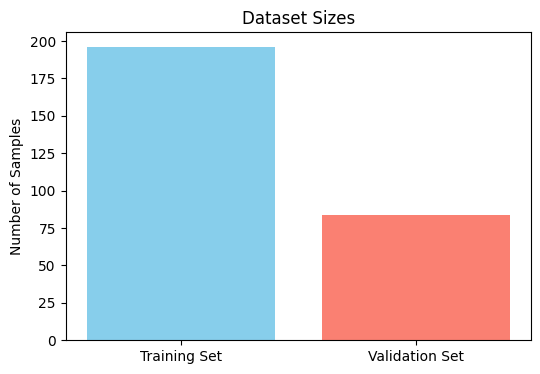

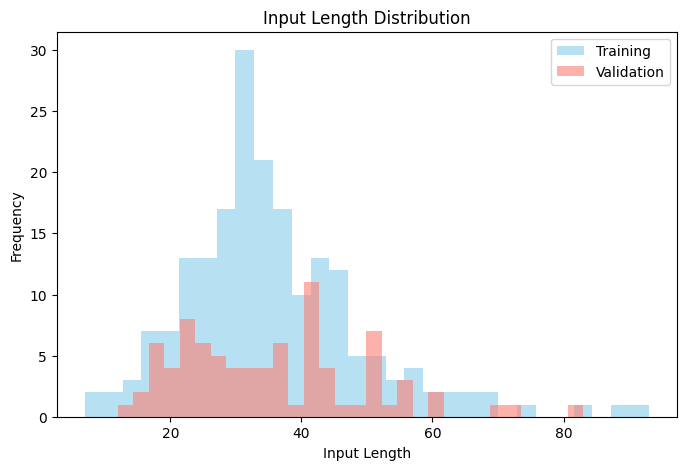

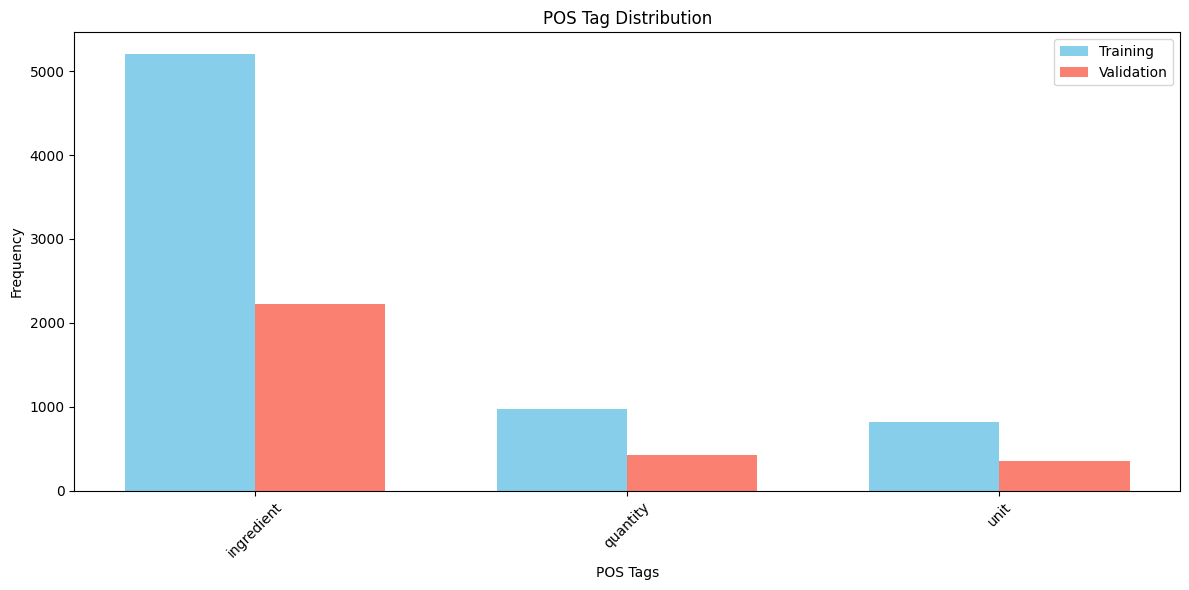

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

def visualize_dataset(train_df, val_df):
    # 1. Dataset Sizes
    sizes = [len(train_df), len(val_df)]
    labels = ['Training Set', 'Validation Set']
    
    plt.figure(figsize=(6, 4))
    plt.bar(labels, sizes, color=['skyblue', 'salmon'])
    plt.title('Dataset Sizes')
    plt.ylabel('Number of Samples')
    plt.show()

    # 2. Input Length Distribution
    plt.figure(figsize=(8, 5))
    plt.hist(train_df['input_length'], bins=30, alpha=0.6, label='Training', color='skyblue')
    plt.hist(val_df['input_length'], bins=30, alpha=0.6, label='Validation', color='salmon')
    plt.title('Input Length Distribution')
    plt.xlabel('Input Length')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    # 3. POS Tag Distribution
    def get_pos_counts(df):
        all_tags = [tag for tokens in df['pos_tokens'] for tag in tokens]
        return Counter(all_tags)

    train_pos_counts = get_pos_counts(train_df)
    val_pos_counts = get_pos_counts(val_df)

    all_tags = sorted(set(train_pos_counts.keys()).union(val_pos_counts.keys()))
    train_counts = [train_pos_counts.get(tag, 0) for tag in all_tags]
    val_counts = [val_pos_counts.get(tag, 0) for tag in all_tags]

    x = range(len(all_tags))
    width = 0.35

    plt.figure(figsize=(12, 6))
    plt.bar([i - width/2 for i in x], train_counts, width=width, label='Training', color='skyblue')
    plt.bar([i + width/2 for i in x], val_counts, width=width, label='Validation', color='salmon')
    plt.xticks(ticks=x, labels=all_tags, rotation=45)
    plt.title('POS Tag Distribution')
    plt.xlabel('POS Tags')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()
visualize_dataset(train_df, val_df)

In [21]:
# print the first five rows of train_df
print(train_df.head())

                                                                                                                                                                                                                                                                                                                                           input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           pos                                                                                                                                          

In [22]:
# print the first five rows of the val_df
print(val_df.head())

                                                                                                                                                                                                                                              input                                                                                                                                                                                                                                                                                                                                                                    pos                                                                                                                                                                                                                                                                        input_tokens                                                                                                                          

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [23]:
# extract the training and validation sets by taking input_tokens and pos_tokens
def extract_token_columns(train_df, val_df):
    """
    Extracts only the 'input_tokens' and 'pos_tokens' columns from training and validation DataFrames.

    Parameters:
    - train_df (pd.DataFrame): Training dataset.
    - val_df (pd.DataFrame): Validation dataset.

    Returns:
    - pd.DataFrame: Training subset with only token columns.
    - pd.DataFrame: Validation subset with only token columns.
    """
    train_subset = train_df[['input_tokens', 'pos_tokens']].copy()
    val_subset = val_df[['input_tokens', 'pos_tokens']].copy()
    return train_subset, val_subset
train_subset, val_subset = extract_token_columns(train_df, val_df)

In [24]:
# validate the shape of training and validation samples
print(train_subset.shape)
print(val_subset.shape)

(196, 2)
(84, 2)


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [25]:
# Display the number of unique labels present in y_train
from itertools import chain
import pandas as pd

def extract_token_columns(train_df, val_df):
    train_subset = train_df[['input_tokens', 'pos_tokens']]
    val_subset = val_df[['input_tokens', 'pos_tokens']]
    return train_subset, val_subset

# Example usage:
train_subset, val_subset = extract_token_columns(train_df, val_df)

# Assign features and labels
X_train = train_subset['input_tokens']
y_train = train_subset['pos_tokens']

# Flatten y_train
flattened_y_train = list(chain.from_iterable(y_train))

# Count unique labels
unique_labels = set(flattened_y_train)
print(f"Number of unique labels in y_train: {len(unique_labels)}")


Number of unique labels in y_train: 3


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [26]:
# flatten the list for nested_list (input_tokens, pos_tokens)
from itertools import chain

# Flatten input_tokens
flattened_input_tokens = list(chain.from_iterable(df['input_tokens']))

# Flatten pos_tokens
flattened_pos_tokens = list(chain.from_iterable(df['pos_tokens']))

# Optional: Display the first few flattened tokens
print("First 10 input tokens:", flattened_input_tokens[:10])
print("First 10 POS tokens:", flattened_pos_tokens[:10])


First 10 input tokens: ['6', 'Karela', 'Bitter', 'Gourd', 'Pavakkai', 'Salt', '1', 'Onion', '3', 'tablespoon']
First 10 POS tokens: ['quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'quantity', 'unit']


In [27]:
#nested_list = input_tokens + pos_tokens
#flattened = [token for sublist in nested_list for token in sublist]


In [28]:
from itertools import chain

# Flatten input_tokens
flattened_input_tokens = list(chain.from_iterable(train_df['input_tokens']))

# Flatten pos_tokens
flattened_pos_tokens = list(chain.from_iterable(train_df['pos_tokens']))

# Optional: print the number of tokens
print(f"Total input tokens: {len(flattened_input_tokens)}")
print(f"Total POS tokens: {len(flattened_pos_tokens)}")
nested_list = flattened_input_tokens + flattened_pos_tokens



Total input tokens: 6992
Total POS tokens: 6992


In [29]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [30]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens

from itertools import chain

def flatten_list(nested_list):
    """Flatten a list of lists."""
    return list(chain.from_iterable(nested_list))

def extract_and_validate_tokens(df, dataset_name):
    print(f"Processing dataset: {dataset_name}")
    
    # Flatten input_tokens and pos_tokens
    flat_input_tokens = flatten_list(df['input_tokens'])
    flat_pos_tokens = flatten_list(df['pos_tokens'])
    
    # Validate lengths
    if len(flat_input_tokens) != len(flat_pos_tokens):
        print(f"⚠️ Length mismatch: input_tokens = {len(flat_input_tokens)}, pos_tokens = {len(flat_pos_tokens)}")
    else:
        print(f"✅ Token lengths match: {len(flat_input_tokens)} tokens")
    
    # Display first 10 token pairs
    print("\nFirst 10 token pairs:")
    for i in range(min(10, len(flat_input_tokens))):
        print(f"{flat_input_tokens[i]} --> {flat_pos_tokens[i]}")


In [31]:
# extract the tokens and its pos tags
extract_and_validate_tokens(train_subset,dataset_name)


Processing dataset: Training
✅ Token lengths match: 6992 tokens

First 10 token pairs:
500 --> quantity
grams --> unit
Chicken --> ingredient
1 --> quantity
Onion --> ingredient
Tomato --> ingredient
2 --> quantity
sprig --> unit
Curry --> ingredient
leaves --> ingredient


#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.

tokens = ["2", "cups", "flour"]
pos_tags = ["QUANTITY", "UNIT", "INGREDIENT"]

ingredients, units, quantities = categorize_tokens(tokens, pos_tags)
print("Ingredients:", ingredients)
print("Units:", units)
print("Quantities:", quantities)


In [32]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays

def categorize_tokens(tokens, pos_tags):
    """
    Categorize tokens into ingredients, units, and quantities based on their POS tags.
    
    Parameters:
        tokens (list): List of tokens (words).
        pos_tags (list): Corresponding list of POS tags.
    
    Returns:
        tuple: (ingredients, units, quantities) if valid, else ([], [], [])
    """
    # Define expected POS tags
    valid_labels = {'ingredient', 'unit', 'quantity'}
    
    # Validate that all tags are within the expected set
    if not all(tag in valid_labels for tag in pos_tags):
        print("Invalid POS tags found. Returning empty lists.")
        return [], [], []
    
    # Initialize categorized lists
    ingredients = [token for token, tag in zip(tokens, pos_tags) if tag == 'ingredient']
    units = [token for token, tag in zip(tokens, pos_tags) if tag == 'unit']
    quantities = [token for token, tag in zip(tokens, pos_tags) if tag == 'quantity']
    
    return ingredients, units, quantities


In [33]:
#  call the function to categorise the labels into respective list
# Flatten the columns
#flat_input_tokens = flatten_list(df1['input_tokens'])
#flat_pos_tokens = flatten_list(df1['pos_tokens'])

# Flatten input_tokens
flattened_input_tokens = list(chain.from_iterable(train_df['input_tokens']))

# Flatten pos_tokens
flattened_pos_tokens = list(chain.from_iterable(train_df['pos_tokens']))
print(f"Total input tokens: {len(flattened_input_tokens)}")
print(f"Total POS tokens: {len(flattened_pos_tokens)}")
nested_list = flattened_input_tokens + flattened_pos_tokens
# Apply the function
ingredients, units, quantities = categorize_tokens(flattened_input_tokens, flattened_pos_tokens)

# Display the results
print("Ingredients:", ingredients)
print("Units:", units)
print("Quantities:", quantities)

Total input tokens: 6992
Total POS tokens: 6992
Ingredients: ['Chicken', 'Onion', 'Tomato', 'Curry', 'leaves', 'Ginger', 'Garlic', 'Paste', 'Turmeric', 'powder', 'Haldi', 'Cumin', 'Jeera', 'roasted', 'Fennel', 'Powder', 'Coriander', 'Dhania', 'Black', 'pepper', 'Salt', 'Sunflower', 'Oil', 'Water', 'Leaves', 'Fresh', 'Figs', 'Lemon', 'juice', 'zest', 'Red', 'Chilli', 'flakes', 'Honey', 'Brown', 'Sugar', '(Demerara', 'Sugar)', 'Green', 'zucchini', 'Salt', 'Extra', 'Virgin', 'Olive', 'Oil', 'Mozzarella', 'cheese', 'finely', 'chopped', 'Red', 'Bell', 'pepper', 'Onion', 'Garlic', 'diced', 'Dried', 'Thyme', 'Leaves', 'Rosemary', 'Chilli', 'flakes', 'Tomatoes', 'Black', 'corns', 'crushed', 'Sugar', 'Basil', 'leaves', 'Brown', 'Rice', 'cooked', 'Garlic', 'chopped', 'Green', 'Chilli', 'Carrots', '(Gajjar)', 'beans', '(French', 'Beans)', 'Bell', 'Pepper', '(Capsicum)', 'Onion', 'Cabbage', '(Patta', 'Gobi/', 'Muttaikose)', 'Roasted', 'tomato', 'pasta', 'sauce', '-', 'or', 'store', 'bought', 'Red'

#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [34]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items

def get_top_frequent_items(item_list, pos_label, dataset_name, top_n=10):
    counter = Counter(item_list)
    top_items = counter.most_common(top_n)
    print(f"\nTop {top_n} {pos_label.lower()}s in {dataset_name} dataset:")
    for item, freq in top_items:
        print(f"{item}: {freq}")
    return top_items


In [35]:
# get the top ingredients which are frequently seen in the recipe

top_ingredients = get_top_frequent_items(ingredients, pos_label="ingredient", dataset_name="Training")



Top 10 ingredients in Training dataset:
powder: 125
Salt: 106
Green: 87
Oil: 85
Red: 84
seeds: 82
chopped: 80
Chilli: 78
Leaves: 72
Coriander: 70


In [36]:
# get the top units which are frequently seen in the recipe
top_units = get_top_frequent_items(units, pos_label="unit", dataset_name="Training")



Top 10 units in Training dataset:
teaspoon: 157
cup: 139
tablespoon: 94
tablespoons: 63
cups: 57
grams: 56
inch: 50
sprig: 42
cloves: 37
teaspoons: 35


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

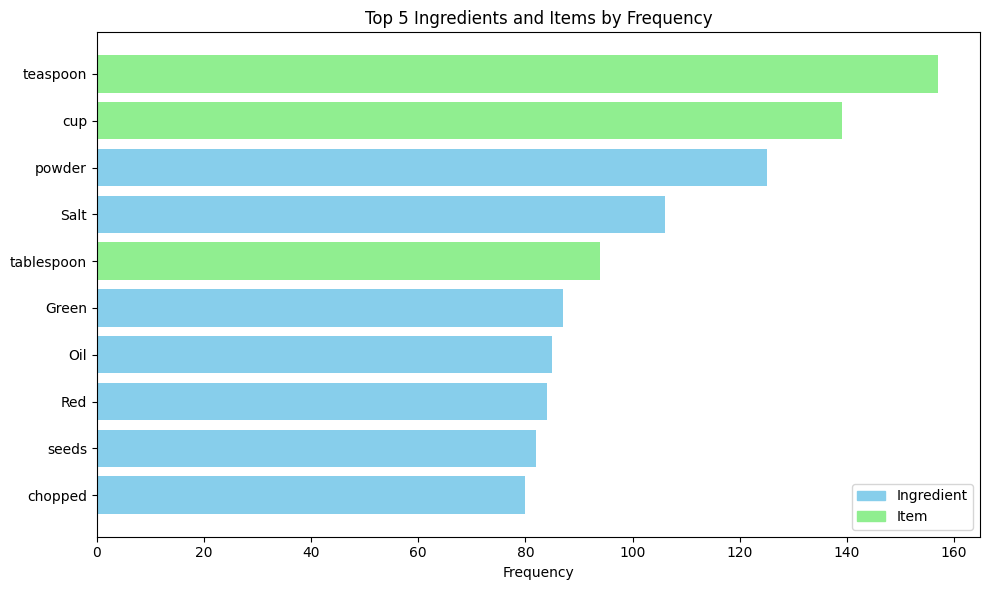

In [37]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name
from matplotlib import pyplot as plt
import numpy as np



# Combine with labels
combined = [(name, count, 'Ingredient') for name, count in top_ingredients] + \
           [(name, count, 'Item') for name, count in top_units]

# Sort by frequency in descending order
combined_sorted = sorted(combined, key=lambda x: x[1], reverse=True)

# Take top 10
top_10_combined = combined_sorted[:10]

# Unpack for plotting
names = [x[0] for x in top_10_combined]
counts = [x[1] for x in top_10_combined]
labels = [x[2] for x in top_10_combined]
colors = ['skyblue' if label == 'Ingredient' else 'lightgreen' for label in labels]

# Plot
plt.figure(figsize=(10, 6))
y_pos = range(len(names))
plt.barh(y_pos, counts, color=colors)
plt.yticks(y_pos, names)
plt.xlabel('Frequency')
plt.title('Top 5 Ingredients and Items by Frequency')
plt.gca().invert_yaxis()
plt.legend(handles=[
    plt.Rectangle((0, 0), 1, 1, color='skyblue', label='Ingredient'),
    plt.Rectangle((0, 0), 1, 1, color='lightgreen', label='Item')
])
plt.tight_layout()
plt.show()


#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



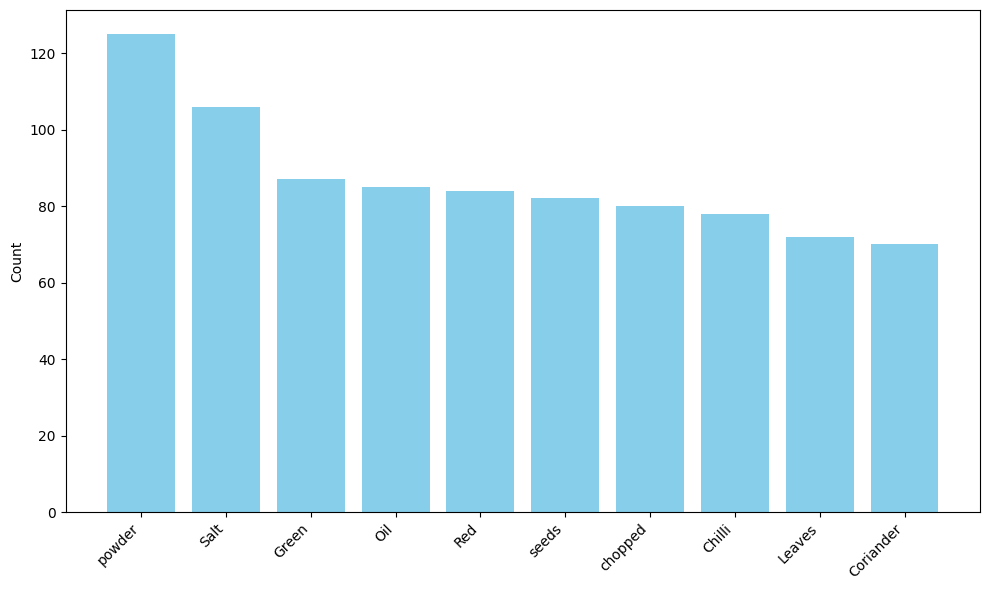

In [38]:
# plot the top frequent ingredients in training data
import matplotlib.pyplot as plt

def plot_top_items(top_items, label, dataset_name):
    """
    Plots a bar chart of the top items.

    Parameters:
    - top_items: List of tuples (item_name, count)
    - label: String indicating the type of item (e.g., 'ingredient' or 'unit')
    - dataset_name: String indicating the name of the dataset
    """
    # Unpack items and counts
    items, counts = zip(*top_items)

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(items, counts, color='skyblue')
    #plt.xlabel(f'{label.capitalize()}')
    plt.ylabel('Count')
    #plt.title(f'Top {label.capitalize()}s in {dataset_name}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_top_items(top_ingredients,units, 'Training')

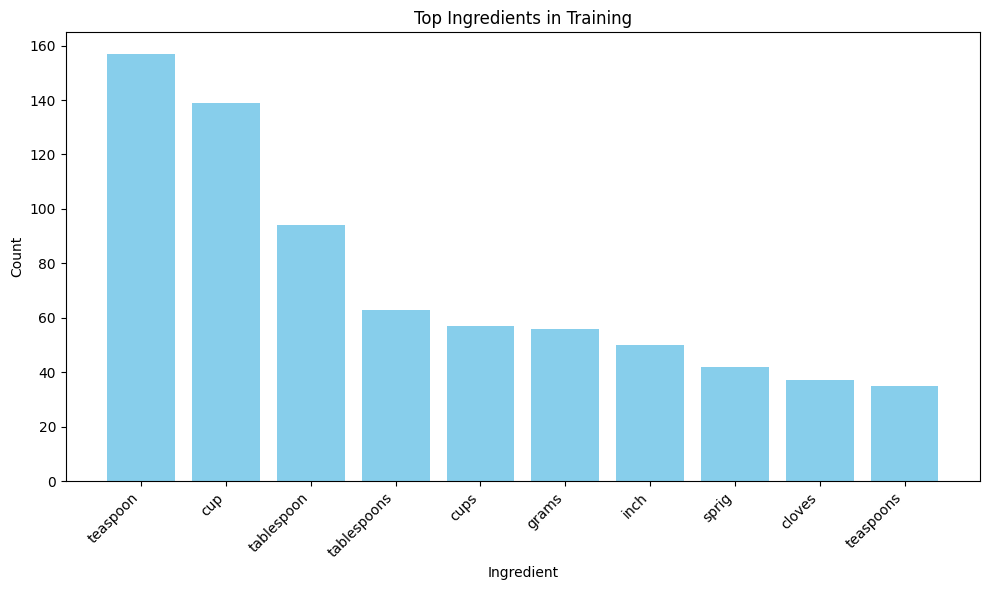

In [39]:
# plot the top frequent units in training data
import matplotlib.pyplot as plt

def plot_top_items(top_items, label, dataset_name):
    """
    Plots a bar chart of the top items.

    Parameters:
    - top_items: List of tuples (item_name, count)
    - label: String indicating the type of item (e.g., 'ingredient' or 'unit')
    - dataset_name: String indicating the name of the dataset
    """
    # Unpack items and counts
    items, counts = zip(*top_items)

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(items, counts, color='skyblue')
    plt.xlabel(f'{label.capitalize()}')
    plt.ylabel('Count')
    plt.title(f'Top {label.capitalize()}s in {dataset_name}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_top_items(top_units, 'ingredient', 'Training')

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [40]:
# initialise the dataset_name
dataset_name='validation'
val_df.head()

,input,pos,input_tokens,pos_tokens,input_length,pos_length,lengths_match
270,1/4 cup lentils green peas 1 onion finely chopped tomato 1/2 inch ginger grated 2 cloves garlic chillies Cut teaspoon turmeric powder salt mustard fenugreek seeds cumin aniseed Kalonji garam masala teaspoons oil asafetida a pinch,quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient,"[1/4, cup, lentils, green, peas, 1, onion, finely, chopped, tomato, 1/2, inch, ginger, grated, 2, cloves, garlic, chillies, Cut, teaspoon, turmeric, powder, salt, mustard, fenugreek, seeds, cumin, aniseed, Kalonji, garam, masala, teaspoons, oil, asafetida, a, pinch]","[quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient]",36,36,True
12,2 cup Tamarind Water 1/2 Arhar dal Split Toor Dal 1 teaspoon Asafoetida hing Salt Mustard seeds Cumin Jeera Methi Seeds Fenugreek sprig Curry leaves pinch Sunflower Oil for cooking,quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient unit ingredient ingredient ingredient ingredient,"[2, cup, Tamarind, Water, 1/2, Arhar, dal, Split, Toor, Dal, 1, teaspoon, Asafoetida, hing, Salt, Mustard, seeds, Cumin, Jeera, Methi, Seeds, Fenugreek, sprig, Curry, leaves, pinch, Sunflower, Oil, for, cooking]","[quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient]",30,30,True
113,1 Brinjal Baingan Eggplant 4 Tomatoes 2 Onions tablespoon Ginger Garlic Paste 20 grams Tamarind teaspoon Mustard seeds Whole Black Peppercorns 1/2 Jaggery 1/4 Turmeric powder Red Chilli teaspoons Sunflower Oil Salt Coriander Dhania Leaves,quantity ingredient ingredient ingredient quantity ingredient quantity ingredient unit ingredient ingredient ingredient quantity unit ingredient unit ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient,"[1, Brinjal, Baingan, Eggplant, 4, Tomatoes, 2, Onions, tablespoon, Ginger, Garlic, Paste, 20, grams, Tamarind, teaspoon, Mustard, seeds, Whole, Black, Peppercorns, 1/2, Jaggery, 1/4, Turmeric, powder, Red, Chilli, teaspoons, Sunflower, Oil, Salt, Coriander, Dhania, Leaves]","[quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",35,35,True
84,250 grams Elephant yam 1/2 green chilli 1 inch ginger 3 tablespoons coriander chopped cup curd teaspoon oil asafetida 1-1/2 Rye Kali Urad Dal Split,quantity unit ingredient ingredient quantity ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient unit ingredient unit ingredient ingredient quantity ingredient ingredi

 # use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe
import pandas as pd
from collections import Counter


# Tokenize input and pos
val_df['input_tokens'] = val_df['input'].apply(lambda x: x.split())
val_df['pos_tokens'] = val_df['pos'].apply(lambda x: x.split())

# Categorize tokens
ingredients = []
units = []

for tokens, pos_tags in zip(val_df['input_tokens'], val_df['pos_tokens']):
    for token, tag in zip(tokens, pos_tags):
        if tag in ['NN', 'NNS']:
            ingredients.append(token.lower())
        elif tag == 'CD':
            continue
        else:
            units.append(token.lower())

# Count frequencies
ingredient_counts = Counter(ingredients)
unit_counts = Counter(units)

# Get top frequent items
top_ingredients = ingredient_counts.most_common(10)
top_units = unit_counts.most_common(10)

# Display results
print("Top Ingredients:")
print(top_ingredients)
print("\nTop Units:")
print(top_units)


In [41]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens

from itertools import chain

def flatten_list(nested_list):
    """Flatten a list of lists."""
    return list(chain.from_iterable(nested_list))

def extract_and_validate_tokens(df, dataset_name):
    print(f"Processing dataset: {dataset_name}")
    
    # Flatten input_tokens and pos_tokens
    flat_input_tokens = flatten_list(df['input_tokens'])
    flat_pos_tokens = flatten_list(df['pos_tokens'])
    
    # Validate lengths
    if len(flat_input_tokens) != len(flat_pos_tokens):
        print(f"⚠️ Length mismatch: input_tokens = {len(flat_input_tokens)}, pos_tokens = {len(flat_pos_tokens)}")
    else:
        print(f"✅ Token lengths match: {len(flat_input_tokens)} tokens")
    
    # Display first 10 token pairs
    print("\nFirst 10 token pairs:")
    for i in range(min(10, len(flat_input_tokens))):
        print(f"{flat_input_tokens[i]} --> {flat_pos_tokens[i]}")

# extract the tokens and its pos tags
extract_and_validate_tokens(val_subset,dataset_name)

# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays

def categorize_tokens(tokens, pos_tags):
    """
    Categorize tokens into ingredients, units, and quantities based on their POS tags.
    
    Parameters:
        tokens (list): List of tokens (words).
        pos_tags (list): Corresponding list of POS tags.
    
    Returns:
        tuple: (ingredients, units, quantities) if valid, else ([], [], [])
    """
    # Define expected POS tags
    valid_labels = {'ingredient', 'unit', 'quantity'}
    
    # Validate that all tags are within the expected set
    if not all(tag in valid_labels for tag in pos_tags):
        print("Invalid POS tags found. Returning empty lists.")
        return [], [], []
    
    # Initialize categorized lists
    ingredients = [token for token, tag in zip(tokens, pos_tags) if tag == 'ingredient']
    units = [token for token, tag in zip(tokens, pos_tags) if tag == 'unit']
    quantities = [token for token, tag in zip(tokens, pos_tags) if tag == 'quantity']
    
    return ingredients, units, quantities

#  call the function to categorise the labels into respective list
# Flatten the columns
#flat_input_tokens = flatten_list(df1['input_tokens'])
#flat_pos_tokens = flatten_list(df1['pos_tokens'])

# Flatten input_tokens
flattened_input_tokens_vf = list(chain.from_iterable(val_df['input_tokens']))

# Flatten pos_tokens
flattened_pos_tokens_vf = list(chain.from_iterable(val_df['pos_tokens']))
print(f"Total input tokens: {len(flattened_input_tokens_vf)}")
print(f"Total POS tokens: {len(flattened_pos_tokens_vf)}")
nested_list_vf = flattened_input_tokens_vf + flattened_pos_tokens_vf
# Apply the function
ingredients_vf, units_vf, quantities_vf = categorize_tokens(flattened_input_tokens, flattened_pos_tokens)

# Display the results
print("Ingredients:", ingredients_vf)
print("Units:", units_vf)
print("Quantities:", quantities_vf)
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items

def get_top_frequent_items(item_list, pos_label, dataset_name, top_n=10):
    counter = Counter(item_list)
    top_items = counter.most_common(top_n)
    print(f"\nTop {top_n} {pos_label.lower()}s in {dataset_name} dataset:")
    for item, freq in top_items:
        print(f"{item}: {freq}")
    return top_items

# get the top ingredients which are frequently seen in the recipe

top_ingredients_vf = get_top_frequent_items(ingredients_vf, pos_label="ingredient", dataset_name="validation")

# get the top units which are frequently seen in the recipe
top_units_vf = get_top_frequent_items(units_vf, pos_label="unit", dataset_name="validation")


Processing dataset: validation
✅ Token lengths match: 2998 tokens

First 10 token pairs:
1/4 --> quantity
cup --> unit
lentils --> ingredient
green --> ingredient
peas --> ingredient
1 --> quantity
onion --> ingredient
finely --> ingredient
chopped --> ingredient
tomato --> ingredient
Total input tokens: 2998
Total POS tokens: 2998
Ingredients: ['Chicken', 'Onion', 'Tomato', 'Curry', 'leaves', 'Ginger', 'Garlic', 'Paste', 'Turmeric', 'powder', 'Haldi', 'Cumin', 'Jeera', 'roasted', 'Fennel', 'Powder', 'Coriander', 'Dhania', 'Black', 'pepper', 'Salt', 'Sunflower', 'Oil', 'Water', 'Leaves', 'Fresh', 'Figs', 'Lemon', 'juice', 'zest', 'Red', 'Chilli', 'flakes', 'Honey', 'Brown', 'Sugar', '(Demerara', 'Sugar)', 'Green', 'zucchini', 'Salt', 'Extra', 'Virgin', 'Olive', 'Oil', 'Mozzarella', 'cheese', 'finely', 'chopped', 'Red', 'Bell', 'pepper', 'Onion', 'Garlic', 'diced', 'Dried', 'Thyme', 'Leaves', 'Rosemary', 'Chilli', 'flakes', 'Tomatoes', 'Black', 'corns', 'crushed', 'Sugar', 'Basil', 'lea

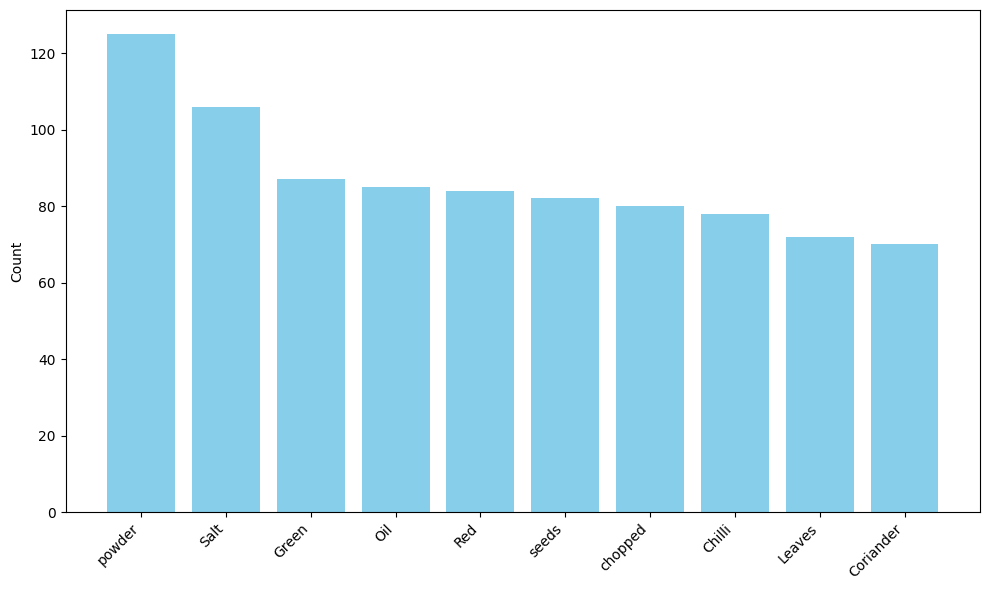

[('powder', 125), ('Salt', 106), ('Green', 87), ('Oil', 85), ('Red', 84), ('seeds', 82), ('chopped', 80), ('Chilli', 78), ('Leaves', 72), ('Coriander', 70)]
[('powder', 125), ('Salt', 106), ('Green', 87), ('Oil', 85), ('Red', 84), ('seeds', 82), ('chopped', 80), ('Chilli', 78), ('Leaves', 72), ('Coriander', 70)]


In [42]:
# plot the top frequent ingredients in validation data
def plot_top_items(top_items, label, dataset_name):
    """
    Plots a bar chart of the top items.

    Parameters:
    - top_items: List of tuples (item_name, count)
    - label: String indicating the type of item (e.g., 'ingredient' or 'unit')
    - dataset_name: String indicating the name of the dataset
    """
    # Unpack items and counts
    items, counts = zip(*top_items)

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(items, counts, color='skyblue')
    #plt.xlabel(f'{label.capitalize()}')
    plt.ylabel('Count')
    #plt.title(f'Top {label.capitalize()}s in {dataset_name}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_top_items(top_ingredients_vf,top_units_vf, 'validation')
print(top_ingredients)
print(top_ingredients_vf)

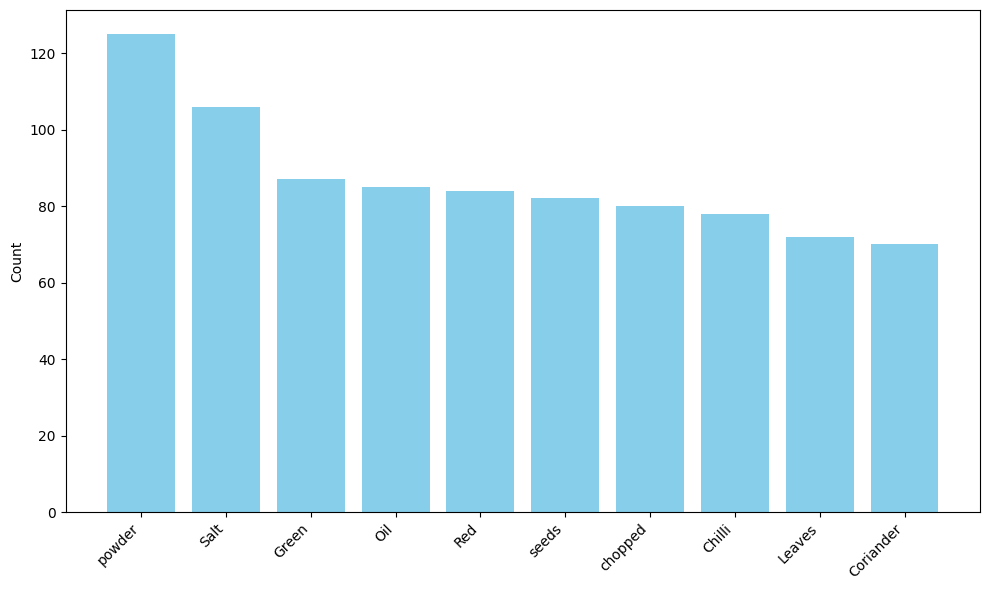

In [43]:
# plot the top frequent units in training data
def plot_top_items(top_items, label, dataset_name):
    """
    Plots a bar chart of the top items.

    Parameters:
    - top_items: List of tuples (item_name, count)
    - label: String indicating the type of item (e.g., 'ingredient' or 'unit')
    - dataset_name: String indicating the name of the dataset
    """
    # Unpack items and counts
    items, counts = zip(*top_items)

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(items, counts, color='skyblue')
    #plt.xlabel(f'{label.capitalize()}')
    plt.ylabel('Count')
    #plt.title(f'Top {label.capitalize()}s in {dataset_name}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_top_items(top_ingredients,top_units, 'Training')


## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [77]:
# define unit and quantity keywords along with quantity pattern


# Define keyword sets
unit_keywords = {
    'cup', 'cups', 'tablespoon', 'tablespoons', 'tbsp',
    'teaspoon', 'teaspoons', 'tsp', 'gram', 'grams', 'g',
    'kilogram', 'kilograms', 'kg', 'ml', 'milliliter', 'milliliters',
    'liter', 'liters', 'l', 'ounce', 'ounces', 'oz',
    'pound', 'pounds', 'lb', 'lbs', 'pinch', 'dash',
    'clove', 'cloves', 'slice', 'slices', 'can', 'cans',
    'package', 'packages', 'stick', 'sticks', 'bottle', 'bottles'
}

quantity_keywords = {
    'half', 'quarter', 'third', 'one', 'two', 'three', 'four', 'five',
    'six', 'seven', 'eight', 'nine', 'ten', 'dozen', 'a', 'an'
}

quantity_pattern = re.compile(r'^\d+(/\d+)?(-\d+(/\d+)?)?$|^\d*\.\d+$')



import pandas as pd
import re

# Sample DataFrame
data = [
    {'input': '1 cup sugar', 'pos': 'CD NN NN'},
    {'input': '2 tablespoons olive oil', 'pos': 'CD NNS JJ NN'},
    {'input': '1/2 teaspoon salt', 'pos': 'CD NN NN'},
    {'input': '3 cups flour', 'pos': 'CD NNS NN'},
    {'input': 'half cup milk', 'pos': 'JJ NN NN'}
]
df = pd.DataFrame(data)



# Function to extract keywords
def extract_keywords(row):
    tokens = row['input'].split()
    pos_tags = row['pos'].split()
    units = []
    quantities = []
    for token, tag in zip(tokens, pos_tags):
        token_lower = token.lower()
        if token_lower in unit_keywords:
            units.append(token)
        elif token_lower in quantity_keywords or quantity_pattern.match(token_lower):
            quantities.append(token)
    return pd.Series({'units': units, 'quantities': quantities})

# Apply the function
df[['units', 'quantities']] = df.apply(extract_keywords, axis=1)

# Display result
print(df)



# Create DataFrame
df_keywords = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in df1]))

# Extract keywords into separate lists
unit_keywords = df_keywords['unit_keywords'].dropna().tolist()
quantity_keywords = df_keywords['quantity_keywords'].dropna().tolist()

# Output
print("Unit Keywords:", unit_keywords)
print("Quantity Keywords:", quantity_keywords)

import json
import pandas as pd

import pandas as pd
import re

# Sample DataFrame
data = [
    {'input': '1 cup sugar', 'pos': 'CD NN NN'},
    {'input': '2 tablespoons olive oil', 'pos': 'CD NNS JJ NN'},
    {'input': '1/2 teaspoon salt', 'pos': 'CD NN NN'},
    {'input': '3 cups flour', 'pos': 'CD NNS NN'},
    {'input': 'half cup milk', 'pos': 'JJ NN NN'}
]
df = pd.DataFrame(data)

# Define keyword sets
unit_keywords = {
    'cup', 'cups', 'tablespoon', 'tablespoons', 'tbsp',
    'teaspoon', 'teaspoons', 'tsp', 'gram', 'grams', 'g',
    'kilogram', 'kilograms', 'kg', 'ml', 'milliliter', 'milliliters',
    'liter', 'liters', 'l', 'ounce', 'ounces', 'oz',
    'pound', 'pounds', 'lb', 'lbs', 'pinch', 'dash',
    'clove', 'cloves', 'slice', 'slices', 'can', 'cans',
    'package', 'packages', 'stick', 'sticks', 'bottle', 'bottles'
}

quantity_keywords = {
    'half', 'quarter', 'third', 'one', 'two', 'three', 'four', 'five',
    'six', 'seven', 'eight', 'nine', 'ten', 'dozen', 'a', 'an'
}

quantity_pattern = re.compile(r'^\d+(/\d+)?(-\d+(/\d+)?)?$|^\d*\.\d+$')

# Function to extract keywords
def extract_keywords(row):
    tokens = row['input'].split()
    pos_tags = row['pos'].split()
    units = []
    quantities = []
    for token, tag in zip(tokens, pos_tags):
        token_lower = token.lower()
        if token_lower in unit_keywords:
            units.append(token)
        elif token_lower in quantity_keywords or quantity_pattern.match(token_lower):
            quantities.append(token)
    return pd.Series({'units': units, 'quantities': quantities})

# Apply the function
df[['units', 'quantities']] = df.apply(extract_keywords, axis=1)

# Display result
print(df)


In [79]:
# load spaCy model
import spacy

# Load the English core model (you can replace 'en_core_web_sm' with another model if needed)
nlp = spacy.load("en_core_web_sm")




##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



import re

# Predefined sets and regex
unit_keywords = {
    "cup", "cups", "tablespoon", "tablespoons", "tbsp", "teaspoon", "teaspoons", "tsp",
    "gram", "grams", "kg", "kilogram", "kilograms", "ml", "milliliter", "milliliters",
    "liter", "liters", "pinch", "dash", "clove", "cloves", "sprig", "sprigs", "inch", "inches",
    "slice", "slices", "piece", "pieces", "drop", "drops", "stick", "sticks"
}

quantity_keywords = {
    "half", "quarter", "third", "one", "two", "three", "four", "five", "six", "seven", "eight",
    "nine", "ten", "few", "several", "some", "dozen", "couple", "1/2", "1/4", "3/4", "1/3", "2/3"
}

quantity_pattern = re.compile(
    r"\b(\d+(\.\d+)?|\d+/\d+|\d+\s*[-–to]+\s*\d+|half|quarter|third)\b",
    re.IGNORECASE
)

def word2features(sent, i):
    token = sent[i]
    text = token.text.lower()

    features = {
        # --- Core Features ---
        'bias': 1.0,
        'token': text,
        'lemma': token.lemma_.lower(),
        'pos_tag': token.pos_,
        'tag': token.tag_,
        'dep': token.dep_,
        'shape': token.shape_,
        'is_stop': token.is_stop,
        'is_digit': token.is_digit,
        'has_digit': any(char.isdigit() for char in token.text),
        'has_alpha': any(char.isalpha() for char in token.text),
        'hyphenated': '-' in token.text,
        'slash_present': '/' in token.text,
        'is_title': token.is_title,
        'is_upper': token.is_upper,
        'is_punct': token.is_punct,

        # --- Improved Quantity and Unit Detection ---
        'is_quantity': text in quantity_keywords or bool(quantity_pattern.match(text)),
        'is_unit': text in unit_keywords,
        'is_numeric': token.like_num,
        'is_fraction': bool(re.match(r'^\d+/\d+$', text)),
        'is_decimal': bool(re.match(r'^\d+\.\d+$', text)),
        'preceding_word': sent[i - 1].text.lower() if i > 0 else '',
        'following_word': sent[i + 1].text.lower() if i < len(sent) - 1 else '',
    }

    # --- Contextual Features ---
    if i > 0:
        prev = sent[i - 1]
        prev_text = prev.text.lower()
        features.update({
            'prev_token': prev_text,
            'prev_is_quantity': prev_text in quantity_keywords or bool(quantity_pattern.match(prev_text)),
            'prev_is_digit': prev.is_digit,
        })
    else:
        features['BOS'] = True

    if i < len(sent) - 1:
        nxt = sent[i + 1]
        next_text = nxt.text.lower()
        features.update({
            'next_token': next_text,
            'next_is_unit': next_text in unit_keywords,
            'next_is_ingredient': next_text not in unit_keywords and next_text not in quantity_keywords and not quantity_pattern.match(next_text),
        })
    else:
        features['EOS'] = True

    return features


In [83]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions

    # Process the entire sentence with spaCy

    # --- Core Features ---

    # --- Improved Quantity & Unit Detection ---

    # --- Contextual Features ---
def word2features(sent, i):
    token = sent[i]
    text = token.text.lower()

    features = {
        # --- Core Features ---
        'bias': 1.0,
        'token': text,
        'lemma': token.lemma_.lower(),
        'pos_tag': token.pos_,
        'tag': token.tag_,
        'dep': token.dep_,
        'shape': token.shape_,
        'is_stop': token.is_stop,
        'is_digit': token.is_digit,
        'has_digit': any(char.isdigit() for char in token.text),
        'has_alpha': any(char.isalpha() for char in token.text),
        'hyphenated': '-' in token.text,
        'slash_present': '/' in token.text,
        'is_title': token.is_title,
        'is_upper': token.is_upper,
        'is_punct': token.is_punct,

        # --- Improved Quantity and Unit Detection ---
        'is_quantity': text in quantity_keywords or bool(quantity_pattern.match(text)),
        'is_unit': text in unit_keywords,
        'is_numeric': token.like_num,
        'is_fraction': bool(re.match(r'^\d+/\d+$', text)),
        'is_decimal': bool(re.match(r'^\d+\.\d+$', text)),
        'preceding_word': sent[i - 1].text.lower() if i > 0 else '',
        'following_word': sent[i + 1].text.lower() if i < len(sent) - 1 else '',
    }

    # --- Contextual Features ---
    if i > 0:
        prev = sent[i - 1]
        prev_text = prev.text.lower()
        features.update({
            'prev_token': prev_text,
            'prev_is_quantity': prev_text in quantity_keywords or bool(quantity_pattern.match(prev_text)),
            'prev_is_digit': prev.is_digit,
        })
    else:
        features['BOS'] = True

    if i < len(sent) - 1:
        nxt = sent[i + 1]
        next_text = nxt.text.lower()
        features.update({
            'next_token': next_text,
            'next_is_unit': next_text in unit_keywords,
            'next_is_ingredient': next_text not in unit_keywords and next_text not in quantity_keywords and not quantity_pattern.match(next_text),
        })
    else:
        features['EOS'] = True

    return features

### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [85]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features
import spacy

# Load spaCy model
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]


# Example sentence
sentence = "2 tablespoons of sugar and 1/2 cup of milk"
doc = nlp(sentence)

# Extract features
features = sent2features(doc)

# View features for each token
for token, feats in zip(doc, features):
    print(f"{token.text}: {feats}")


2: {'bias': 1.0, 'token': '2', 'lemma': '2', 'pos_tag': 'NUM', 'tag': 'CD', 'dep': 'nummod', 'shape': 'd', 'is_stop': False, 'is_digit': True, 'has_digit': True, 'has_alpha': False, 'hyphenated': False, 'slash_present': False, 'is_title': False, 'is_upper': False, 'is_punct': False, 'is_quantity': True, 'is_unit': False, 'is_numeric': True, 'is_fraction': False, 'is_decimal': False, 'preceding_word': '', 'following_word': 'tablespoons', 'BOS': True, 'next_token': 'tablespoons', 'next_is_unit': True, 'next_is_ingredient': False}
tablespoons: {'bias': 1.0, 'token': 'tablespoons', 'lemma': 'tablespoon', 'pos_tag': 'NOUN', 'tag': 'NNS', 'dep': 'ROOT', 'shape': 'xxxx', 'is_stop': False, 'is_digit': False, 'has_digit': False, 'has_alpha': True, 'hyphenated': False, 'slash_present': False, 'is_title': False, 'is_upper': False, 'is_punct': False, 'is_quantity': False, 'is_unit': True, 'is_numeric': False, 'is_fraction': False, 'is_decimal': False, 'preceding_word': '2', 'following_word': 'of',

### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [86]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features
# Assuming train_sents and val_sents are lists of spaCy Doc objects or tokenized sentences

# Define sent2features if not already defined
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

# Example: Create X_train_features and X_val_features
X_train_features = [sent2features(sent) for sent in train_sents]
X_val_features = [sent2features(sent) for sent in val_sents]

# Output the number of feature sets created
print(f"Number of training feature sets: {len(X_train_features)}")
print(f"Number of validation feature sets: {len(X_val_features)}")



NameError: name 'train_sents' is not defined

##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [87]:
# Convert labels into list as y_train_labels and y_val_labels
import json
import random
import re
import spacy
from sklearn.model_selection import train_test_split

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Load the JSON file
with open("ingredient_and_quantity.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Define unit and quantity keywords and pattern
unit_keywords = {
    "cup", "cups", "tablespoon", "tablespoons", "tbsp", "teaspoon", "teaspoons", "tsp",
    "gram", "grams", "kg", "kilogram", "kilograms", "ml", "milliliter", "milliliters",
    "liter", "liters", "pinch", "dash", "clove", "cloves", "sprig", "sprigs", "inch", "inches",
    "slice", "slices", "piece", "pieces", "drop", "drops", "stick", "sticks"
}

quantity_keywords = {
    "half", "quarter", "third", "one", "two", "three", "four", "five", "six", "seven", "eight",
    "nine", "ten", "few", "several", "some", "dozen", "couple", "1/2", "1/4", "3/4", "1/3", "2/3"
}

quantity_pattern = re.compile(
    r"\b(\d+(\.\d+)?|\d+/\d+|\d+\s*[-–to]+\s*\d+|half|quarter|third)\b",
    re.IGNORECASE
)

# Define BIO labeling function
def label_token(token):
    text = token.text.lower()
    if text in unit_keywords:
        return "B-UNIT"
    elif text in quantity_keywords or quantity_pattern.match(text):
        return "B-QUANTITY"
    elif token.is_alpha and not token.is_stop:
        return "B-INGREDIENT"
    else:
        return "O"

# Prepare sentences and labels
sentences = []
labels = []

for entry in data:
    doc = nlp(entry["ingredients"])
    sentences.append(doc)
    labels.append([label_token(token) for token in doc])

# Split into training and validation sets
train_sents, val_sents, train_labels, val_labels = train_test_split(sentences, labels, test_size=0.2, random_state=42)

# Define feature extraction functions
def word2features(sent, i):
    token = sent[i]
    text = token.text.lower()
    features = {
        'bias': 1.0,
        'token': text,
        'lemma': token.lemma_.lower(),
        'pos_tag': token.pos_,
        'tag': token.tag_,
        'dep': token.dep_,
        'shape': token.shape_,
        'is_stop': token.is_stop,
        'is_digit': token.is_digit,
        'has_digit': any(char.isdigit() for char in token.text),
        'has_alpha': any(char.isalpha() for char in token.text),
        'hyphenated': '-' in token.text,
        'slash_present': '/' in token.text,
        'is_title': token.is_title,
        'is_upper': token.is_upper,
        'is_punct': token.is_punct,
        'is_quantity': text in quantity_keywords or bool(quantity_pattern.match(text)),
        'is_unit': text in unit_keywords,
        'is_numeric': token.like_num,
        'is_fraction': bool(re.match(r'^\d+/\d+$', text)),
        'is_decimal': bool(re.match(r'^\d+\.\d+$', text)),
        'preceding_word': sent[i - 1].text.lower() if i > 0 else '',
        'following_word': sent[i + 1].text.lower() if i < len(sent) - 1 else '',
    }

    if i > 0:
        prev = sent[i - 1]
        prev_text = prev.text.lower()
        features.update({
            'prev_token': prev_text,
            'prev_is_quantity': prev_text in quantity_keywords or bool(quantity_pattern.match(prev_text)),
            'prev_is_digit': prev.is_digit,
        })
    else:
        features['BOS'] = True

    if i < len(sent) - 1:
        nxt = sent[i + 1]
        next_text = nxt.text.lower()
        features.update({
            'next_token': next_text,
            'next_is_unit': next_text in unit_keywords,
            'next_is_ingredient': next_text not in unit_keywords and next_text not in quantity_keywords and not quantity_pattern.match(next_text),
        })
    else:
        features['EOS'] = True

    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

# Generate features and labels
X_train_features = [sent2features(s) for s in train_sents]
X_val_features = [sent2features(s) for s in val_sents]
y_train_labels = train_labels
y_val_labels = val_labels

# Output the number of training and validation samples
print(f"Training samples: {len(X_train_features)}")
print(f"Validation samples: {len(X_val_features)}")



KeyError: 'ingredients'

##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [50]:
# print the length of train features and labels


In [51]:
# print the length of validation features and labels


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [52]:
# Flatten labels in y_train


##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [53]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [54]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts


In [55]:
# penalise ingredient label


##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [56]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)


##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [57]:
# Apply manually computed class weights


## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [58]:
# initialise CRF model with the specified hyperparameters and use weight_dict

# train the CRF model with the weighted training data


### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [59]:
# evaluate on the training dataset


In [60]:
# specify the flat classification report by using training data for evaluation


In [61]:
# create a confusion matrix on training datset


### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [62]:
# dump the model using joblib as crf_model.pkl


## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [63]:
# predict the crf model on validation dataset


In [64]:
# specify flat classification report


In [65]:
# create a confusion matrix on validation dataset


## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [66]:
# flatten Labels and Initialise Error Data


##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [67]:
# iterate and collect Error Information

            # get previous and next tokens with handling for boundary cases


##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [68]:
# Create DataFrame and Print Overall Accuracy


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [69]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context



### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




 <font color = red>[Write your answer]</font>

## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.